In [1]:
!pip install torcheval


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.6 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
import torchvision
from torcheval.metrics import BinaryAUROC

In [3]:
torch.cuda.is_available()

True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
competition_dir = "/kaggle/input/histopathologic-cancer-detection/"

label_df = pd.read_csv(competition_dir+"train_labels.csv")
label_df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [6]:
import os
from pathlib import Path

train_dir = Path(competition_dir+"train")
test_dir = Path(competition_dir+"test")


def walk_through_dir(dir_path):
    """
      Walks through dir_path returning its contents.
      Args:
        dir_path (str or pathlib.Path): target directory
  
      Returns:
        A print out of:
          number of subdiretories in dir_path
          number of images (files) in each subdirectory
          name of each subdirectory
      """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
#walk_through_dir(train_dir)
#walk_through_dir(test_dir)

ID: 38c20f292d6b4cd45acfd67bc6d516c5d2639ad2 | Label: 1


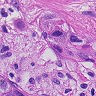

In [8]:
import random
from PIL import Image

image_path_list = list(train_dir.glob("*.tif"))

random_image_path = random.choice(image_path_list)

random_image_id = random_image_path.stem
random_image_label = label_df[label_df['id'] == random_image_id].label.values[0]

print(f"ID: {random_image_id} | Label: {random_image_label}")

img = Image.open(random_image_path)
img

In [9]:
def my_train_test_split(total_df: pd.DataFrame, split_proportion: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    """Function to split the dataset in training and test according to a given proportion between 0 and 1   
    """
    
    train_df = total_df.sample(frac = split_proportion)
    test_df = total_df.drop(train_df.index)
    
    return train_df, test_df

In [10]:
#Start training with only 5% of the avauilable data
big_df, small_df = my_train_test_split(label_df, 0.95)

train_df, test_df = my_train_test_split(small_df, 0.7)

test_df

,id,label
273,336b8b8fbcb3df72a114eddd35f33a5b7542ea21,1
365,b387400d9cdeb5c1fd90fb7758ab25203d0527f8,0
426,496627cf8196e992dd5e76231dd7db6f6d71fcbd,0
428,3af463e2df35946db06b1edaf53a70f3263a05f6,0
491,7ce16340f6c47b9b9ba7f4b43463ed6e841d5cbf,0
...,...,...
219606,9b890b776097c466feb103e31d939d5185bb77e8,1
219687,74c5673664ad8170f4b04570dc28b973529144cf,1
219787,66673629b5f06dadf013b43355ea25da75536515,0
219852,c5b35bfe01c1aa2ad29223169a823acbeaa4c141,1


In [11]:
from torch.utils.data import Dataset
import pathlib

class DatasetGenerator(Dataset):
    
    def __init__(self, targ_dir: str, labels_df: pd.DataFrame, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir)/(im_id+".tif") for im_id in labels_df['id']) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.labels_df = labels_df
        
    def load_image(self, index: int) -> Tuple[Image.Image, str]:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        image_id = self.paths[index].stem
        return Image.open(image_path), image_id
    
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img, image_id = self.load_image(index)
        label = self.labels_df[self.labels_df['id'] == image_id].label.values[0]

        # Transform if necessary
        if self.transform:
            return self.transform(img), label # return data, label (X, y)
        else:
            return img, label # return data, label (X, y)

In [12]:
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 157MB/s]


In [13]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [14]:
train_data = DatasetGenerator(competition_dir+"train",train_df, transform = auto_transforms)

In [15]:
im, l = train_data[10]
im

tensor([[[2.0092, 2.0092, 1.9920,  ..., 2.1462, 2.2147, 2.2147],
         [2.0092, 2.0092, 1.9920,  ..., 2.1462, 2.2147, 2.2147],
         [1.9920, 1.9920, 1.9749,  ..., 2.1119, 2.1633, 2.1633],
         ...,
         [2.0605, 2.0605, 2.0605,  ..., 1.3584, 1.3927, 1.3927],
         [2.0605, 2.0605, 2.0605,  ..., 1.4269, 1.4612, 1.4612],
         [2.0605, 2.0605, 2.0605,  ..., 1.4269, 1.4612, 1.4612]],

        [[2.1835, 2.1835, 2.1660,  ..., 2.0084, 2.1134, 2.1134],
         [2.1835, 2.1835, 2.1660,  ..., 2.0084, 2.1134, 2.1134],
         [2.1660, 2.1660, 2.1485,  ..., 1.9909, 2.0784, 2.0784],
         ...,
         [2.2185, 2.2185, 2.2185,  ..., 0.1702, 0.1877, 0.1877],
         [2.2185, 2.2185, 2.2185,  ..., 0.2402, 0.2577, 0.2577],
         [2.2185, 2.2185, 2.2185,  ..., 0.2402, 0.2577, 0.2577]],

        [[2.3960, 2.3960, 2.3786,  ..., 2.4657, 2.5529, 2.5529],
         [2.3960, 2.3960, 2.3786,  ..., 2.4657, 2.5529, 2.5529],
         [2.3786, 2.3786, 2.3611,  ..., 2.4308, 2.5006, 2.

In [16]:
test_data = DatasetGenerator(competition_dir+"train",test_df, transform = auto_transforms)
im, l = test_data[10]
im

tensor([[[1.7523, 1.7523, 1.8037,  ..., 2.2489, 2.2489, 2.2489],
         [1.7523, 1.7523, 1.8037,  ..., 2.2489, 2.2489, 2.2489],
         [1.7352, 1.7352, 1.7865,  ..., 2.0434, 2.0263, 2.0263],
         ...,
         [1.2728, 1.2728, 1.3413,  ..., 1.6324, 1.6667, 1.6667],
         [1.1529, 1.1529, 1.2557,  ..., 1.5982, 1.6324, 1.6324],
         [1.1529, 1.1529, 1.2557,  ..., 1.5982, 1.6324, 1.6324]],

        [[1.2381, 1.2381, 1.2906,  ..., 1.8683, 1.8683, 1.8683],
         [1.2381, 1.2381, 1.2906,  ..., 1.8683, 1.8683, 1.8683],
         [1.2206, 1.2206, 1.2906,  ..., 1.6232, 1.6057, 1.6057],
         ...,
         [0.5028, 0.5028, 0.5728,  ..., 1.0105, 1.0455, 1.0455],
         [0.3627, 0.3627, 0.4678,  ..., 0.9930, 1.0280, 1.0280],
         [0.3627, 0.3627, 0.4678,  ..., 0.9930, 1.0280, 1.0280]],

        [[1.8208, 1.8208, 1.8731,  ..., 2.3263, 2.3263, 2.3263],
         [1.8208, 1.8208, 1.8731,  ..., 2.3263, 2.3263, 2.3263],
         [1.8034, 1.8034, 1.8557,  ..., 2.0823, 2.0648, 2.

In [17]:
len(train_data), len(test_data)

(7701, 3300)

In [18]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, # use custom created test Dataset
                                    batch_size=BATCH_SIZE, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79a0bffbf9d0>,
 <torch.utils.data.dataloader.DataLoader at 0x79a0b9206f80>)

In [19]:
import torchinfo

torchinfo.summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   648                  True
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   48                   True
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 24, 112

In [20]:
#Freeze all layers
for param in model.features.parameters():
    param.requires_grad = False

In [21]:
#Substitute last layer for my specific binary classification model
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=1, # same number of output units as our number of classes
                    bias=True)).to(device)

In [22]:
torchinfo.summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   (648)                False
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   (48)                 False
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 

In [23]:
#pip install torch-lr-finder


In [24]:
#from torch_lr_finder import LRFinder


In [25]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr= 0.01)

##TO DO: Implement one-cycle learning rate scheduler 

In [26]:
#lr_finder = LRFinder(model, optimizer, loss_fn, device=device)
#lr_finder.range_test(train_dataloader, end_lr=100, num_iter=100)
#lr_finder.plot() # to inspect the loss-learning rate graph
#lr_finder.reset() # to reset the model and optimizer to their initial state

In [27]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    
    model.train()

    # Setup train loss and train accuracy values
    metric = BinaryAUROC()

    train_loss, train_auc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device, dtype = torch.float)

        # 1. Forward pass
        y_pred = model(X)
        
        y_pred_2 = torch.sigmoid(y_pred)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred_2.squeeze(), y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.round(torch.sigmoid(y_pred))
        
        metric.update(y_pred_2.squeeze(), y)
        i = metric.compute()
        i.item()
        train_auc += i

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_auc = train_auc / len(dataloader)
    return train_loss, train_auc

In [28]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    
    # Put model in eval mode
    model.eval() 

    metric = BinaryAUROC()

    # Setup test loss and test accuracy values
    test_loss, test_auc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device, dtype = torch.float)

            # 1. Forward pass
            test_pred_logits = model(X)
            
            test_pred_logits_2 = torch.sigmoid(test_pred_logits)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits_2.squeeze(), y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = torch.round(torch.sigmoid(test_pred_logits))
            
            metric.update(test_pred_logits_2.squeeze(), y)
            i = metric.compute()
            i.item()
            test_auc += i

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_auc = test_auc / len(dataloader)
    return test_loss, test_auc

In [29]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
        "train_auc": [],
        "test_loss": [],
        "test_auc": []
    }

  # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_auc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_auc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_auc: {train_auc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_auc: {test_auc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_auc"].append(train_auc)
        results["test_loss"].append(test_loss)
        results["test_auc"].append(test_auc)

    # Return the filled results at the end of the epochs
    return results

In [30]:
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results

results = train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=1,
            device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6356 | train_auc: 0.6514 | test_loss: 0.5645 | test_auc: 0.8786
[INFO] Total training time: 242.073 seconds


In [31]:
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f="/kaggle/working/models/EffNet_Baseline.pth")

RuntimeError: Parent directory /kaggle/working/models does not exist.

With no fine-tuning, the model already achieved a reasonable accuracy (AUC 0.84), using only 10% of the data

# Fine-Tuning

In [ ]:
from pathlib import Path

#MODEL_SAVE_PATH = Path("/kaggle/working/models/EffNet_Baseline.pth")
MODEL_SAVE_PATH = "/kaggle/working/models/EffNet_Baseline.pth"
model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=1, # same number of output units as our number of classes
                    bias=True)).to(device)

model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
#Unfreeze other layers 
for param in model.features.parameters():
    param.requires_grad = True

In [ ]:
torchinfo.summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)



In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr= 0.01)

In [ ]:
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results

results_fine_tuning = train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=5,
            device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f="/kaggle/working/models/EffNet_FineTune_Naive.pth")

## Fine Tuning with Discriminative Learning Rate

In [ ]:
MODEL_SAVE_PATH = "/kaggle/working/models/EffNet_Baseline.pth"
model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=1, # same number of output units as our number of classes
                    bias=True)).to(device)

model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
#Unfreeze other layers 
for param in model.features.parameters():
    param.requires_grad = True

In [ ]:
torchinfo.summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [ ]:
def discriminative_lr_generator(model: nn.Module, max_lr: float, mult: float) -> List[Dict[nn.Module.parameters, float]]:
    layer_names = []
    for idx, (name, param) in enumerate(model.named_parameters()):
        layer_names.append(name)
        
    layer_names.reverse()
        
    lr      = max_lr
    lr_mult = mult

    # placeholder
    parameters      = []
    prev_group_name = layer_names[0].split('.')[1]

    # store params & learning rates
    for idx, name in enumerate(layer_names):

        # parameter group name
        cur_group_name = name.split('.')[1]

        # update learning rate
        if cur_group_name != prev_group_name:
            lr *= lr_mult
        prev_group_name = cur_group_name

        # display info
        print(f'{idx}: lr = {lr:.6f}, {name}')

        # append layer parameters
        parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                        'lr':     lr}]
        
    return parameters


In [ ]:
parameters = discriminative_lr_generator(model,1e-2,0.5)


In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(parameters)

In [ ]:
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results

results_fine_tuning = train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=5,
            device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f="/kaggle/working/models/EffNet_FineTune_Discriminative_Lr.pth")

With fine-tuning, the model obtained excellent performances, but it seems to be slightly overfitting, as the training loss  continued the decreasing while the test loss plateaued. 

I can try to train with the rest of the dataset in order to improve the performance.

## Test with 50% of data

In [ ]:
big_df, small_df = my_train_test_split(label_df, 0.9)

train_df, test_df = my_train_test_split(small_df, 0.7)

train_data = DatasetGenerator(competition_dir+"train",train_df, transform = auto_transforms)
test_data = DatasetGenerator(competition_dir+"train",test_df, transform = auto_transforms)

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, # use custom created test Dataset
                                    batch_size=BATCH_SIZE, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data


In [ ]:
from pathlib import Path

#MODEL_SAVE_PATH = Path("/kaggle/working/models/EffNet_Baseline.pth")
MODEL_SAVE_PATH = "/kaggle/working/models/EffNet_Baseline.pth"
model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=1, # same number of output units as our number of classes
                    bias=True)).to(device)

model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
#Unfreeze other layers 
for param in model.features.parameters():
    param.requires_grad = True

In [ ]:
torchinfo.summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


In [ ]:

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr= 0.01)

In [ ]:
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results

results_fine_tuning = train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=5,
            device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f="/kaggle/working/models/EffNet_FineTune_Naive_90pct.pth")

### Test on testing dataset